In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from analysis import *
import pickle as pkl

In [2]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, \
    Input, BatchNormalization, multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

import pydot as pyd
from tensorflow.keras.utils import plot_model, model_to_dot
import tensorflow
tensorflow.keras.utils.pydot = pyd

Read Data

In [3]:
data = pkl.load(open('../Data/data.pkl', 'rb'))

X_input_train = data['X_input_train']
X_output_train = data['X_output_train']
X_input_test = data['X_input_test']
X_output_test = data['X_output_test']

x_trend_param = data['x_trend_param']
x_train_max = data['x_train_max']

Model

In [4]:
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))
n_hidden = 100
print(input_train)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 200, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 1), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [5]:
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_sequences=False, return_state=True)(input_train)
print(encoder_last_h1)
print(encoder_last_h2)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/strided_slice_3:0', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/while:4', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/while:5', description="created by layer 'lstm'")


In [6]:
encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1) 
print(encoder_last_h1)

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='batch_normalization/batchnorm/add_1:0', description="created by layer 'batch_normalization'")


In [7]:
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c) 
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='batch_normalization_1/batchnorm/add_1:0', description="created by layer 'batch_normalization_1'")


In [8]:
decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
print(decoder)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='repeat_vector/Tile:0', description="created by layer 'repeat_vector'")


In [9]:
decoder = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
               return_state=False, return_sequences=True)(
    decoder, initial_state=[encoder_last_h1, encoder_last_c])
print(decoder)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='lstm_1/transpose_1:0', description="created by layer 'lstm_1'")


In [10]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 1), dtype=tf.float32, name=None), name='time_distributed/Reshape_1:0', description="created by layer 'time_distributed'")


In [11]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 1)]     0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 100),        40800       ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 batch_normalization (BatchNorm  (None, 100)         400         ['lstm[0][0]']                   
 alization)                                                                                   

C:\Users\manue\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [13]:
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :1], X_output_train[:, :, :1], validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=300)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
model.save('model_forecasting_seq2seq.h5')

Epoch 1/100
21/21 [==============================] - 20s 760ms/step - loss: 3.4331 - mae: 0.7600 - val_loss: 0.1432 - val_mae: 0.3062
Epoch 2/100
21/21 [==============================] - 18s 850ms/step - loss: 0.1227 - mae: 0.2710 - val_loss: 0.0944 - val_mae: 0.2470
Epoch 3/100
21/21 [==============================] - 21s 1s/step - loss: 0.1070 - mae: 0.2488 - val_loss: 0.0961 - val_mae: 0.2359
Epoch 4/100
21/21 [==============================] - 22s 1s/step - loss: 0.0918 - mae: 0.2272 - val_loss: 0.0689 - val_mae: 0.2075
Epoch 5/100
21/21 [==============================] - 23s 1s/step - loss: 0.0683 - mae: 0.1986 - val_loss: 0.0619 - val_mae: 0.1952
Epoch 6/100
21/21 [==============================] - 25s 1s/step - loss: 0.0440 - mae: 0.1576 - val_loss: 0.0319 - val_mae: 0.1366
Epoch 7/100
21/21 [==============================] - 27s 1s/step - loss: 0.0369 - mae: 0.1439 - val_loss: 0.0224 - val_mae: 0.1137
Epoch 8/100
21/21 [==============================] - 25s 1s/step - loss: 0.03

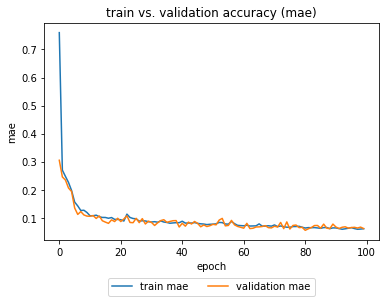

In [14]:
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

Predict

In [15]:
train_pred_detrend = model.predict(X_input_train[:, :, :1])*x_train_max[:2]
test_pred_detrend = model.predict(X_input_test[:, :, :1])*x_train_max[:2]
print(train_pred_detrend.shape, test_pred_detrend.shape)

train_true_detrend = X_output_train[:, :, :1]*x_train_max[:2]
test_true_detrend = X_output_test[:, :, :1]*x_train_max[:2]
print(train_true_detrend.shape, test_true_detrend.shape)

(7800, 20, 2) (1981, 20, 2)
(7800, 20, 2) (1981, 20, 2)


In [16]:
# combine with the index
train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 1], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 1], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 1], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 1], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

(7800, 20, 3) (1981, 20, 3)
(7800, 20, 3) (1981, 20, 3)


In [18]:
# recover trend
data_final = dict()

for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x = dt[:, :, 0] + (dt[:, :, 1]**2)*x_trend_param[0] + dt[:, :, 1]*x_trend_param[1]
    data_final[lb] = np.expand_dims(dt_x, axis=2)

print(lb+': {}'.format(data_final[lb].shape))

test_true: (1981, 20, 1)


In [19]:
for k in ['train_pred', 'train_true', 'test_pred', 'test_true']:
    print('maximum: {}'.format(k))
    print(data_final[k].max())

maximum: train_pred
14574598.683579858
maximum: train_true
14537428.751193766
maximum: test_pred
15498978.42152754
maximum: test_true
20394044.748420224


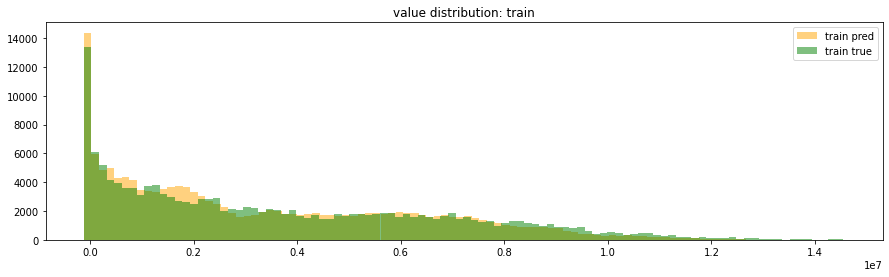

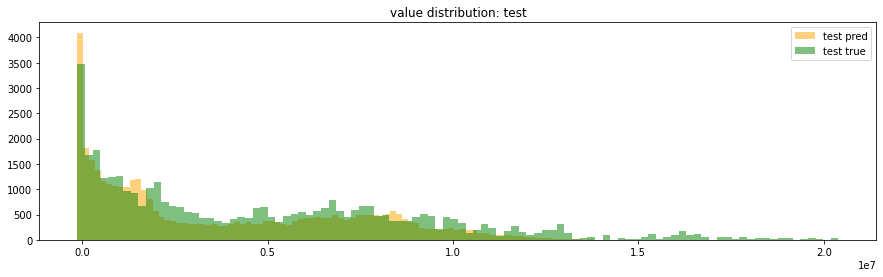

In [20]:
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

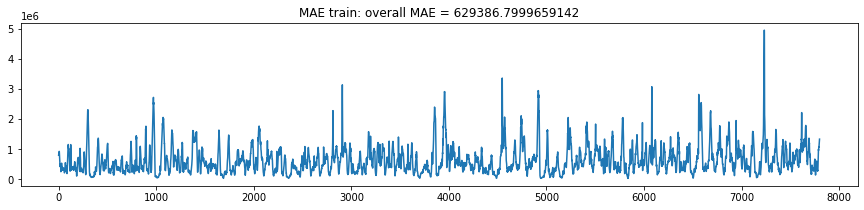

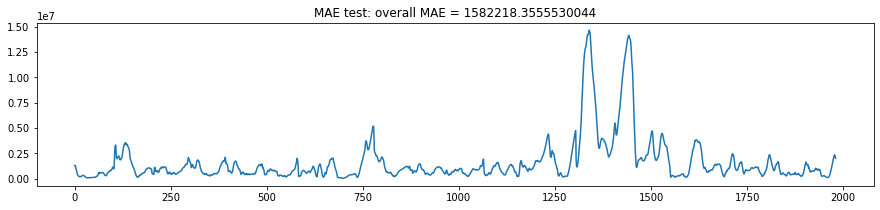

In [21]:
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show() 

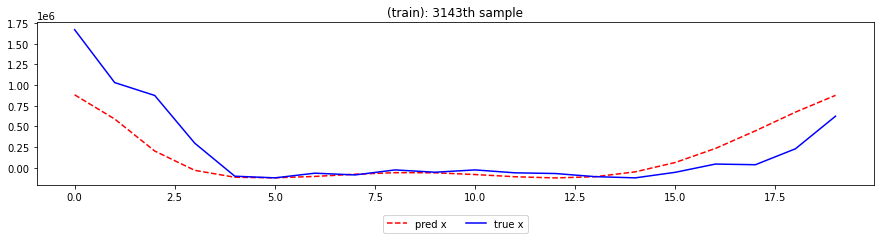

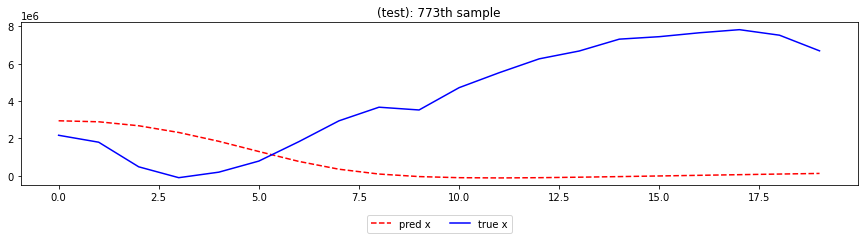

In [22]:
import random

for lb in ['train', 'test']:
    ith_sample = random.choice(range(data_final[lb+'_pred'].shape[0]))

    plt.figure(figsize=(15,3))
    plt.plot(data_final[lb+'_pred'][ith_sample, :, 0], linestyle='--', color='r', label='pred x')
    plt.plot(data_final[lb+'_true'][ith_sample, :, 0], linestyle='-', color='b', label='true x')
    plt.title('({}): {}th sample'.format(lb, ith_sample))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
    plt.show()

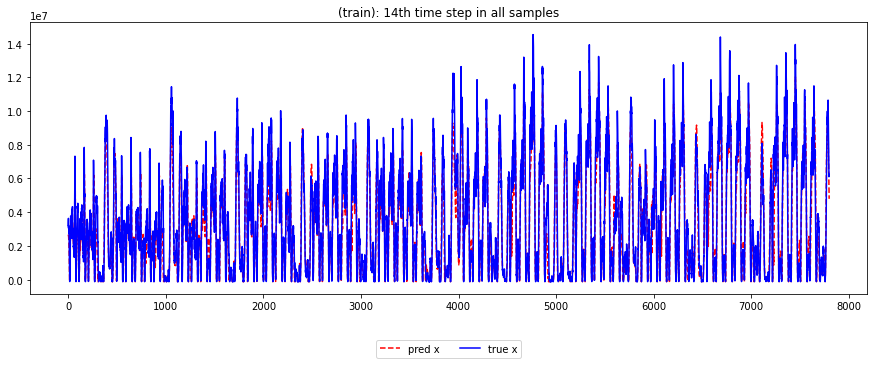

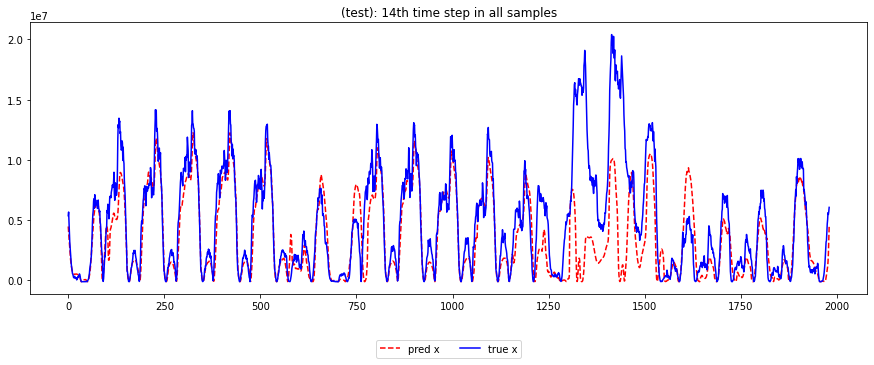

In [23]:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
for lb in ['train', 'test']:   
    plt.figure(figsize=(15, 5))
    plt.plot(data_final[lb+'_pred'][:, ith_timestep, 0], linestyle='--', color='r', label='pred x')
    plt.plot(data_final[lb+'_true'][:, ith_timestep, 0], linestyle='-', color='b', label='true x')
    plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
    plt.show()

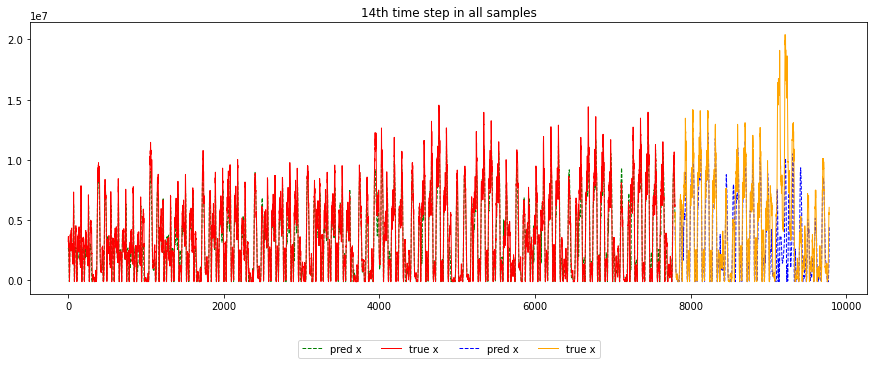

In [24]:
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                data_final[lb+'_pred'][:, ith_timestep, 0], 
                linestyle='--', linewidth=1, color=clrs[0], label='pred x')
    plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                data_final[lb+'_true'][:, ith_timestep, 0], 
                linestyle='-', linewidth=1, color=clrs[1], label='true x')
    
    
plt.title(f'{ith_timestep}th time step in all samples')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

In [26]:
pkl.dump(data_final, open('../Data/results.pkl', 'wb'))

In [28]:
import h5py

filename = "model_forecasting_seq2seq.h5"
h5 = h5py.File(filename, 'r')
h5.keys()

<KeysViewHDF5 ['model_weights', 'optimizer_weights']>

In [42]:
h5['model_weights']

<HDF5 group "/model_weights" (8 members)>

In [54]:
from tensorflow import keras
model = keras.models.load_model(filename)



AttributeError: 'Functional' object has no attribute 'keys'

In [55]:
import h5py

filename = "model_forecasting_seq2seq.h5"
h5 = h5py.File(filename, 'r')

In [56]:
h5.keys()

<KeysViewHDF5 ['model_weights', 'optimizer_weights']>

In [57]:
h5['model_weights']

<HDF5 group "/model_weights" (8 members)>